In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torchmetrics.classification import Accuracy
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import ToTensor
import torch.utils.data as data

class VGGLightning(pl.LightningModule):
    def __init__(self, train_set, valid_set, batch_size=128, num_classes=10):
        super(VGGLightning, self).__init__()
        
        # Define VGG architecture for 28x28 MNIST images (grayscale)
        self.features = nn.Sequential(
            # First block: Conv -> Conv -> MaxPool
            nn.Conv2d(1, 64, kernel_size=3, padding=1),  # 1 input channel (grayscale), 64 output channels
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: 64x14x14

            # Second block: Conv -> Conv -> MaxPool
            nn.Conv2d(64, 128, kernel_size=3, padding=1),  # 64 input channels, 128 output channels
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: 128x7x7

            # Third block: Conv -> Conv -> Conv -> MaxPool
            nn.Conv2d(128, 256, kernel_size=3, padding=1),  # 128 input channels, 256 output channels
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # Output size: 256x3x3

            # Fourth block: Conv -> Conv -> Conv -> MaxPool
            nn.Conv2d(256, 512, kernel_size=3, padding=1),  # 256 input channels, 512 output channels
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # Output size: 512x1x1
        )
        
        # Fully connected layers
        self.classifier = nn.Sequential(
            nn.Linear(512 * 1 * 1, 4096),  # Adjusted to 512 * 1 * 1 based on input size
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)  # Output 10 classes for MNIST digits
        )

        # Metric for accuracy
        self.accuracy = Accuracy(task="multiclass", num_classes=num_classes)

        # Define batch_size
        self.batch_size = batch_size

        # Define datasets
        self.train_set = train_set
        self.valid_set = valid_set

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the output from convolutional layers
        x = self.classifier(x)
        return x

    def train_dataloader(self):
        return DataLoader(self.train_set, batch_size=self.batch_size, num_workers=11, persistent_workers=True)

    def training_step(self, batch, batch_idx):
        # Extract input images and labels
        images, labels = batch
        
        # Forward pass
        outputs = self(images)
        
        # Calculate loss (cross-entropy loss)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        # Log training loss
        self.log('train_loss', loss, on_epoch=True)
        
        return loss

    def val_dataloader(self):
        return DataLoader(self.valid_set, batch_size=self.batch_size, num_workers=11, persistent_workers=True)

    def validation_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        
        # Calculate loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        # Calculate accuracy
        acc = self.accuracy(outputs, labels)
        
        self.log('val_loss', loss, on_epoch=True)
        self.log('val_acc', acc, on_epoch=True)
        
        return loss

    def test_step(self, batch, batch_idx):
        images, labels = batch
        outputs = self(images)
        
        # Calculate loss
        loss = nn.CrossEntropyLoss()(outputs, labels)
        
        # Calculate accuracy
        acc = self.accuracy(outputs, labels)
        
        self.log('test_loss', loss, on_epoch=True)
        self.log('test_acc', acc, on_epoch=True)
        
        return loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr=0.001)
        scheduler = {
            'scheduler': torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1),
            'monitor': 'val_loss'
        }
        
        return [optimizer], [scheduler]

    def predict_step(self, batch, batch_idx, dataloader_idx=0):
        images, labels = batch 
        outputs = self(images)
        # Get the predicted class with the highest prob
        _, predicted = torch.max(outputs, 1) 
        return images, labels, predicted

In [7]:
from torch.utils.data import DataLoader

# Define datasets
training_set = datasets.MNIST(root="data", train=True, download=True, transform=ToTensor())
# use 20% of training data for validation
train_set_size = int(len(training_set) * 0.8)
valid_set_size = len(training_set) - train_set_size
# split the train set into two
seed = torch.Generator().manual_seed(42)
train_set, valid_set = data.random_split(training_set, [train_set_size, valid_set_size], generator=seed)

# Initialize model 
model = VGGLightning(train_set, valid_set)

# Create a Trainer object
trainer = pl.Trainer(default_root_dir="checkpoints/", callbacks=[pl.callbacks.EarlyStopping(monitor="val_loss", mode="min")], max_epochs=-1)

# Tune batch scale
# tuner = pl.tuner.Tuner(trainer)
# tuner.scale_batch_size(model)

# Train the model
trainer.fit(model)

# Validate training
test_set = datasets.MNIST(root="data", train=False, download=True, transform=ToTensor())
test_dataloader = DataLoader(test_set, num_workers=11, persistent_workers=True)
trainer.test(model, test_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type               | Params | Mode 
----------------------------------------------------------
0 | features   | Sequential         | 7.6 M  | train
1 | classifier | Sequential         | 18.9 M | train
2 | accuracy   | MulticlassAccuracy | 0      | train
----------------------------------------------------------
26.6 M    Trainable params
0         Non-trainable params
26.6 M    Total params
106.231   Total estimated model params size (MB)
34        Modules in train mode
0         Modules in eval mode


Testing DataLoader 0: 100%|██████████| 10000/10000 [00:55<00:00, 180.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_acc          │    0.11349999904632568    │
│         test_loss         │     2.301114559173584     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 2.301114559173584, 'test_acc': 0.11349999904632568}]

In [4]:
# Make predictions
predictions = trainer.predict(model, test_dataloader)

Predicting DataLoader 0: 100%|██████████| 10000/10000 [00:47<00:00, 210.64it/s]


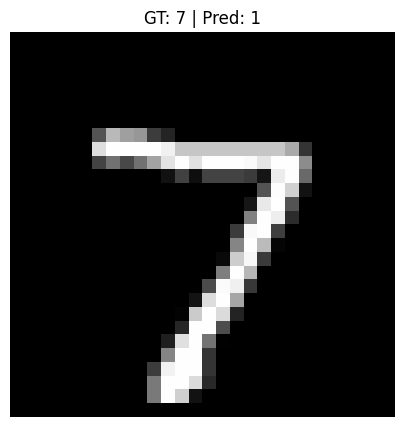

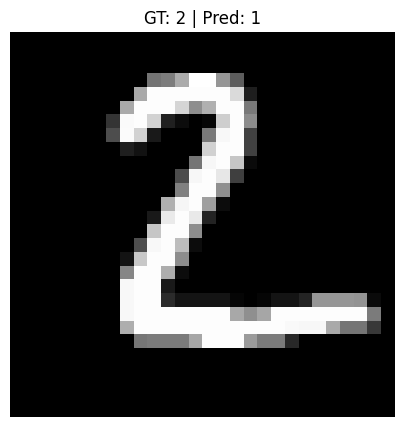

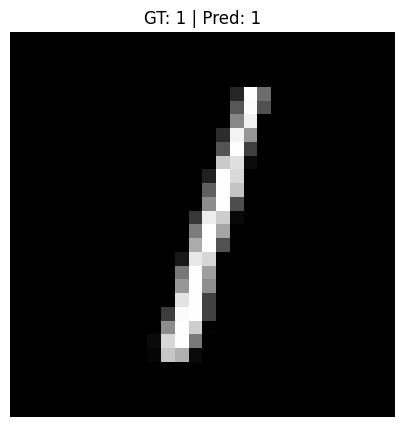

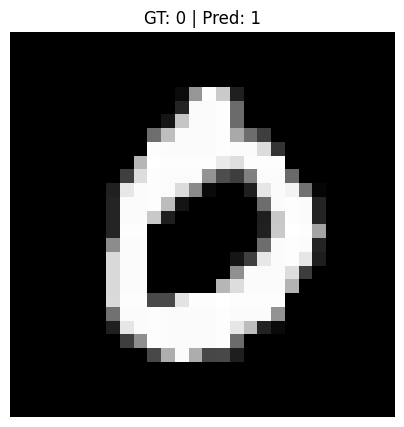

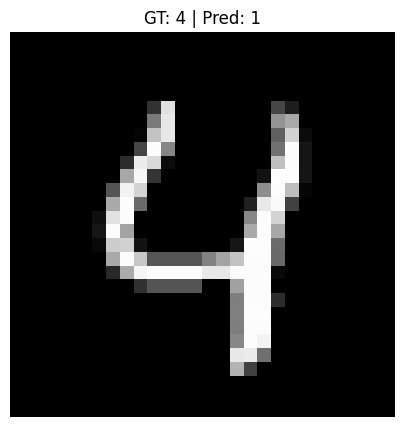

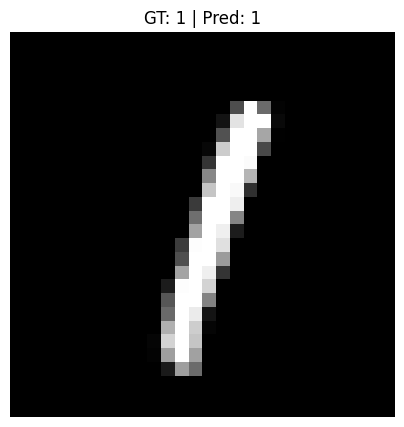

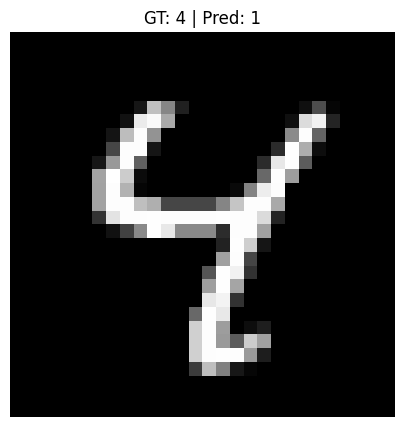

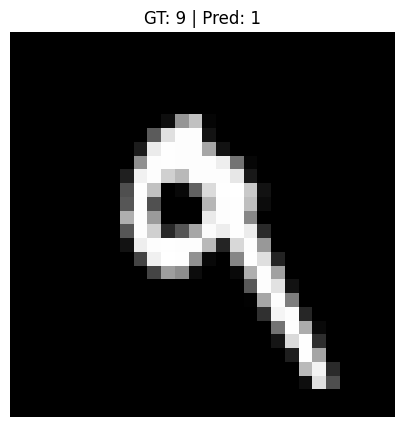

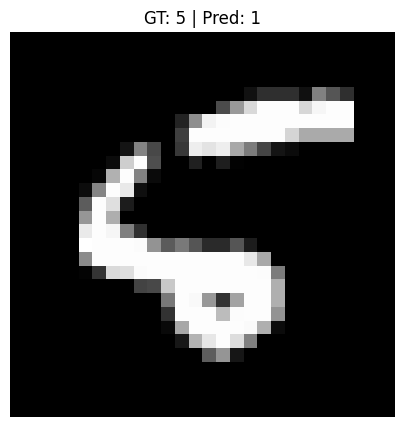

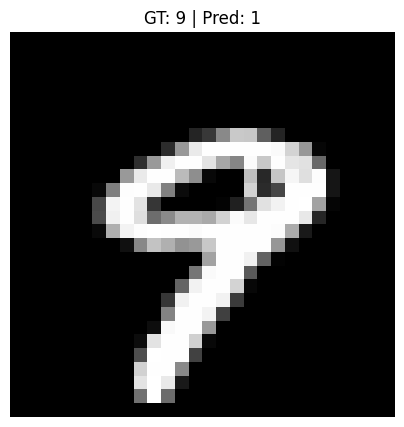

In [5]:
import matplotlib.pyplot as plt

# Visualizing predictions along with their ground truth and predicted labels
for images, labels, preds in predictions[:10]:
    # Convert tensor images to numpy for plotting
    images = images.squeeze(1).cpu().numpy()
    labels = labels.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plot images with ground truth and prediction labels
    for i in range(len(images)):
        fig, ax = plt.subplots(1, 1, figsize=(5, 5))
        ax.imshow(images[i], cmap='gray')
        ax.set_title(f"GT: {labels[i]} | Pred: {preds[i]}")
        ax.axis('off')
        plt.show()

In [6]:
# Save model 
script = model.to_torchscript()

# save for use in production environment
torch.jit.save(script, "model.pt")